# GOES – R

NOAA's latest generation of Geostationary Operational Environmental Satellites (GOES) is the nation's most advanced fleet of geostationary weather satellites. Geostationary satellites are those that circle the Earth in geosynchronous orbit, that is, they orbit the Earth's equatorial plane at a speed corresponding to the Earth's rotation. This causes the satellite to remain in a fixed position in the sky, remaining stationary in relation to a point on the ground (nadir). GOES satellites continuously observe the western part of the planet from approximately 36,000 km above Earth.


In [ ]:
#-------------------------------------------------------------------------------
# MANIPULATION OF GOES 16 SATELLITE DATA         #
# THESE CODE HAS THE FOCUS MANIPULATION OF       #
# GOES 16 SATELLITE DATA USING PYTHON LANGUAGE   #
# TO OPEN AND PLOT IMAGES OF BAND'S              #
# AUTHOR: DOUGLAS LIMA DE BEM                    #
# LAST UPDATE: 2023-11-07                        #
#-------------------------------------------------------------------------------

# Required packages and Python libraries

Here, we will install all the Python libraries necessary to be able to analyze and plot the maps of the different GOES-16 bands. Furthermore, we will use some utilities which will be acquired through the utilities.py code. The shapefile of the Brazilian states will also be used and a CPT file to generate the set of colors necessary for a good representation of the IR channel.

In [ ]:
# INSTALL MODULES USING PIP#
!pip install matplotlib
!pip install cartopy
!pip install numpy
!pip install xarray
!pip install goes2go

# Downloading the shapefile of the Brazilian states
!wget -c https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2019/Brasil/BR/br_unidades_da_federacao.zip
print('\n')

# Decompressing the shapefile of Brazilian states
!unzip -o br_unidades_da_federacao.zip
print('\n')

# Example CPT file download (for highlighting IR channels)
!wget -c https://www.dropbox.com/s/fdgnaqt91cy3x97/IR4AVHRR6.cpt
print('\n')

#Download the "cpt_convert.py" script
#!wget -c https://github.com/guidocioni/eumetsat-python/blob/master/cpt_convert.py

!wget -c https://www.dropbox.com/s/3li94noxkv08ypa/cpt_convert.py


# Download example CPT file (for highlighting WV channels)
!wget -c https://www.dropbox.com/s/j1rf1brc69ontwq/WVCOLOR35.cpt
print('\n')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.5/400.5 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.0/294.0 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 86.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2023.6.0
    Uninstalling fsspec-2023.6.0:
      Successfully uninstalled fsspec-2023.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2023.6.0 requires fsspec==2023.6.0, but you have fsspec 2023.10.0 which is incompatible.
--2023-11-07 21:41:28--  https://geoftp.ibge.gov.br/organizacao_do_territorio/

# Opening and manipulating GOES 16 data using goes2go

In [ ]:
from datetime import datetime,timedelta
from goes2go import GOES
import cartopy,cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import xarray
import cartopy.io.shapereader as shpreader
from cpt_convert import loadCPT
from matplotlib import cm                           # Colormap handling utilities
from matplotlib.colors import LinearSegmentedColormap # Linear interpolation for color maps


# ABI Multi-Channel Cloud Moisture Imagry Product
G = GOES(satellite=16, product="ABI-L2-MCMIPF", domain='F')

X = GOES(satellite=16,product="GLM-L2-LCFA",domain='F')

# Download and read the latest data as an xarray Dataset
ds = G.latest()

dx = X.latest()

# Scan's start time, converted to datetime object
scan_start = datetime.strptime(str(ds.time_coverage_start.values), '%Y-%m-%dT%H:%M:%S.%fZ')
print(scan_start,'\n')
# Scan's end time, converted to datetime object
scan_end = datetime.strptime(str(ds.time_coverage_end.values), '%Y-%m-%dT%H:%M:%S.%fZ')
print(scan_end,'\n')
# File creation time, convert to datetime object
file_created = datetime.strptime(str(ds.date_created.values), '%Y-%m-%dT%H:%M:%S.%fZ')
print(file_created,'\n')

 ╭─────────────────────────────────────────────────╮
 │ I'm building goes2go's default config file.     │
 ╰╥────────────────────────────────────────────────╯
 👷🏻‍♂️
⚙ Created config file [/root/.config/goes2go/config.toml] with default values.


📦 Finished downloading [1] files to [/root/data/noaa-goes16/ABI-L2-MCMIPF].
📚 Finished reading [1] files into xarray.Dataset.
📦 Finished downloading [1] files to [/root/data/noaa-goes16/GLM-L2-LCFA].
📚 Finished reading [1] files into xarray.Dataset.
2023-11-07 21:30:20.700000 

2023-11-07 21:39:52.700000 

2023-11-07 21:40:00.100000 



# Visible Channel Plot

Now, we will open the RGB bands necessary to be able to image the visible channel. In the case of GOES 16, bands 01,02,03 correspond to:

R = Band 02 (0.64 um)

G = Band 03 (0.87 um)

B = Band 01 (0.47 um)

In [ ]:
# Confirm that each band is the wavelength we are interested in
for band in [2, 3, 1]:
    print('{} is {:.2f} {}'.format(
        ds['band_wavelength_C{:02d}'.format(band)].long_name,
        float(ds['band_wavelength_C{:02d}'.format(band)][0]),
        ds['band_wavelength_C{:02d}'.format(band)].units))


ABI band 2 central wavelength is 0.64 um
ABI band 3 central wavelength is 0.87 um
ABI band 1 central wavelength is 0.47 um


In [ ]:
ds

<xarray.Dataset>
Dimensions:                                 (y: 5424, x: 5424,
                                             number_of_time_bounds: 2,
                                             number_of_image_bounds: 2, band: 1)
Coordinates: (12/41)
    t                                       datetime64[ns] 2023-11-07T21:35:0...
  * y                                       (y) float64 0.1518 ... -0.1518
  * x                                       (x) float64 -0.1518 ... 0.1518
    y_image                                 float32 0.0
    x_image                                 float32 0.0
    band_wavelength_C01                     (band) float32 0.47
    ...                                      ...
    band_id_C15                             (band) int8 15
    band_id_C16                             (band) int8 16
    dataset_name                            <U74 'OR_ABI-L2-MCMIPF-M6_G16_s20...
    date_created                            <U22 '2023-11-07T21:40:00.1Z'
    time_coverage_start                     <U22 '2023-11-07T21:30:20.7Z'
    time_coverage_end                       <U22 '2023-11-07T21:39:52.7Z'
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                band
Data variables: (12/125)
    CMI_C01                                 (y, x) float32 nan nan ... nan nan
    DQF_C01                                 (y, x) float32 nan nan ... nan nan
    CMI_C02                                 (y, x) float32 nan nan ... nan nan
    DQF_C02                                 (y, x) float32 nan nan ... nan nan
    CMI_C03                                 (y, x) float32 nan nan ... nan nan
    DQF_C03                                 (y, x) float32 nan nan ... nan nan
    ...                                      ...
    std_dev_brightness_temperature_C16      float32 16.75
    percent_uncorrectable_GRB_errors        float32 0.0
    percent_uncorrectable_L0_errors         float32 0.0
    dynamic_algorithm_input_data_container  int32 -2147483647
    algorithm_product_version_container     int32 -2147483647
    filename                                <U112 'noaa-goes16/ABI-L2-MCMIPF/...
Attributes: (12/26)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    cdm_data_type:             Image
    processing_level:          National Aeronautics and Space Administration ...
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        52e43ab2-7bc5-465a-8e7c-04e8dae66b8d
    path:                      ['noaa-goes16/ABI-L2-MCMIPF/2023/311/21/OR_ABI...

After confirming that the bands are in the correct spectrum, we will call each band from the file we downloaded previously. This file will be a dataset and will store all the bands for the entire GOES 16 mesh. The np.clip, given an interval, values outside the interval are clipped to the interval edges. For example, if an interval of [0, 1] is specified, values smaller than 0 become 0, and values larger than 1 become 1.

In [ ]:
# Load the RGB arrays
R = ds['CMI_C02'][:].data
G = ds['CMI_C03'][:].data
B = ds['CMI_C01'][:].data

# Apply range limits for each channel. RGB values must be between 0 and 1. Given an interval, values outside the interval are clipped to the interval edges.
R = np.clip(R, 0, 1)
G = np.clip(G, 0, 1)
B = np.clip(B, 0, 1)

Gamma correction is normally applied in these cases. A gamma correction is applied to control the brightness and make the image not look too dark.

    corrected_value = value^(1/gamma)

Most displays have a decoding gamma of 2.2. Furthermore, we will apply a green correction to get the "True green". he GREEN “veggie” channel on GOES-16 does not measure visible green light. Instead, it measures a near-infrared band sensitive to chlorophyll. We could use that channel in place of green, but it would make the green in our image appear too vibrant. Instead, we will tone-down the green channel by interpolating the value to simulate a natural green color.

    True_Green =  (0.45*red) + (0.1*green) + (0.45*blue)



In [ ]:
# Apply the gamma correction
gamma = 1.5
R = np.power(R, 1/gamma)
G = np.power(G, 1/gamma)
B = np.power(B, 1/gamma)

# Calculate the "True" Green
G_true = 0.48358168 * R + 0.45706946 * B + 0.06038137 * G
G_true = np.clip(G_true, 0, 1)

# The final RGB array :)
RGB = np.dstack([R, G_true, B])    #np.dstack provide stacking and concatenation operations

print(RGB[RGB>0])

[0.00465364 0.00465364 0.00465364 ... 0.37763384 0.42721146 0.4767732 ]


Now, with the RGB matrix composed and ready to use, we can start generating the visible channel figure. Initially we will choose the size of the figure and the extent of the GOES data we want to plot. In this case, all of South America is being chosen. Furthermore, we transform the GOES data projection and add the shape of the division of Brazilian states and countries.

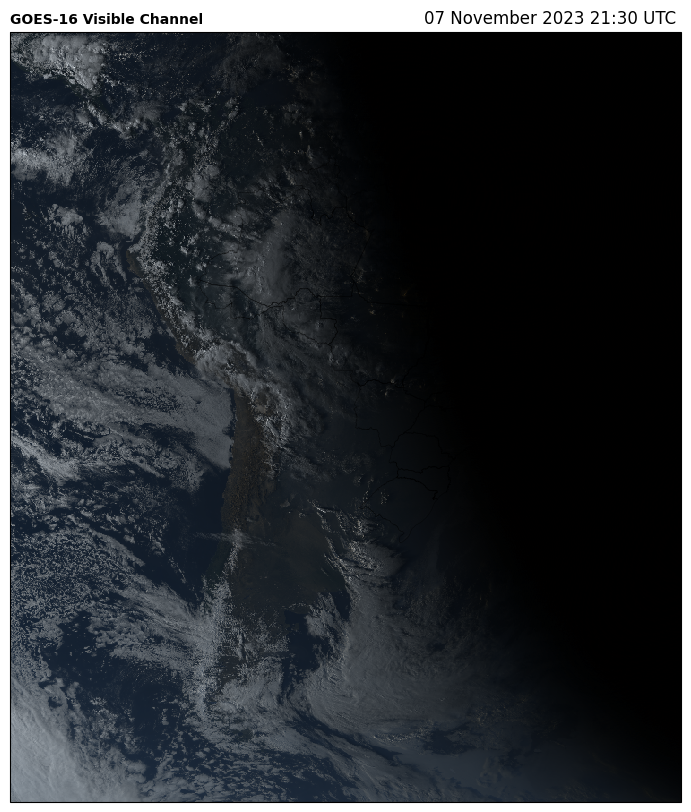

In [ ]:
# Choose the plot size (width x height, in inches)
plt.figure(figsize=(12,10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-103.3))
extent=ax.set_extent([-93.0, -25.0, -60.0, 18.0], crs=ccrs.PlateCarree())
#extent=ax.set_extent([-43.0, -25.0, -60.0, -40.0], crs=ccrs.PlateCarree())

ax.imshow(RGB, origin='upper', extent=extent,transform=ccrs.Geostationary(central_longitude=-75.0, satellite_height=35786023.0),interpolation='none')

# Add a shapefile
shapefile = list(shpreader.Reader('BR_UF_2019.shp').geometries())
ax.add_geometries(shapefile, ccrs.PlateCarree(), edgecolor='black',facecolor='none', linewidth=0.2)

plt.title('GOES-16 Visible Channel', loc='left', fontweight='bold', fontsize=10)
plt.title('{}'.format(scan_start.strftime('%d %B %Y %H:%M UTC ')), loc='right')
# plt.savefig('visible_'+scan_start.strftime('%Y-%m-%d %H:%M')+'.png', bbox_inches='tight', pad_inches=0, dpi=100)
plt.show()

# "Clean" IR Longwave Window Channel Plot

In this case, we will work with band 13 of GOES channel 16, which refers to the “clean” longwave infrared window band. Also known as a channel that is used to visualize the brightness temperature of clouds, for a meteorologist it is extremely important to analyze this data to observe the intensification and development of convection during the period in question. As done in the visible channel, we will observe whether the data used can provide us with data from this band, in this case band 13.

In [ ]:
print('{} is {:.2f} {}'.format(
ds['band_wavelength_C{:02d}'.format(13)].long_name,
float(ds['band_wavelength_C{:02d}'.format(13)][0]),
ds['band_wavelength_C{:02d}'.format(13)].units))

ABI band 13 central wavelength is 10.33 um


We will use the same libraries used previously, so there is no need to load them again. Furthermore, we will use the data from the downloaded .cpt files to create the necessary color palette for the best visualization of this data.

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


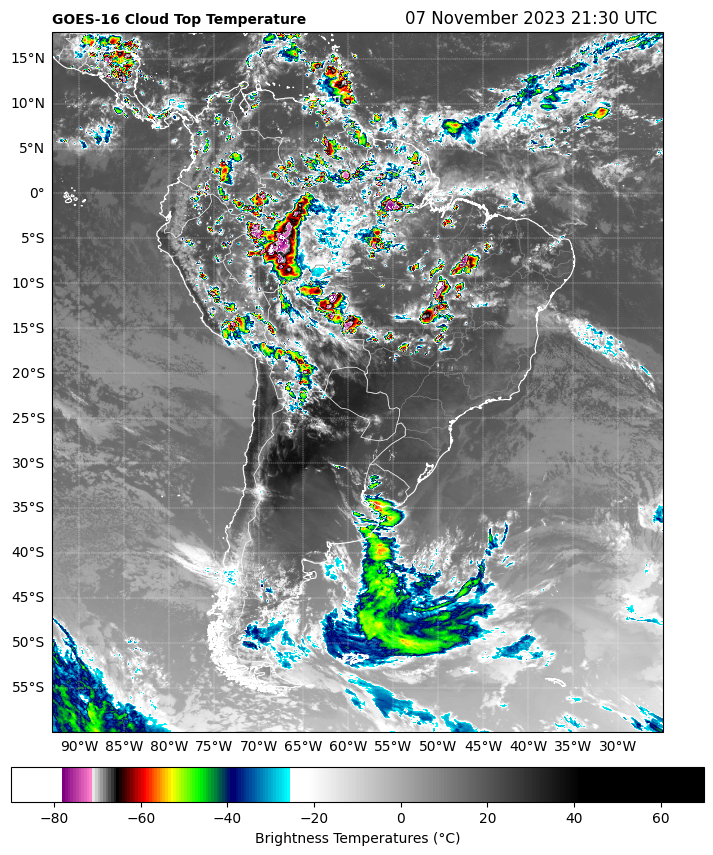

In [ ]:
# Load the the thermal infrared arrays
IR = ds['CMI_C13'][:,:].data - 273.15

# Choose the plot size (width x height, in inches)
plt.figure(figsize=(12,10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-103.3))
extent=ax.set_extent([-93.0, -25.0, -60.0, 18.0], crs=ccrs.PlateCarree())

# Converts the CPT file to be used in Python
cpt = loadCPT('IR4AVHRR6.cpt')

# Makes a linear interpolation with the CPT file
cpt_convert = LinearSegmentedColormap('cpt', cpt)

# Plot the image
img = plt.imshow(IR, vmin=-90, vmax=70,cmap=cpt_convert, origin='upper', extent=extent, transform=ccrs.Geostationary(central_longitude=-75.0, satellite_height=35786023.0))

# Add a shapefile
# https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2019/Brasil/BR/br_unidades_da_federacao.zip
shapefile = list(shpreader.Reader('BR_UF_2019.shp').geometries())
ax.add_geometries(shapefile, ccrs.PlateCarree(), edgecolor='gray',facecolor='none', linewidth=0.3)

# Add coastlines, borders and gridlines
ax.coastlines(resolution='10m', color='white', linewidth=0.8)
ax.add_feature(cartopy.feature.BORDERS, edgecolor='white', linewidth=0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), color='white', alpha=1.0, linestyle='--', linewidth=0.25, xlocs=np.arange(-180, 180, 5), ylocs=np.arange(-90, 90, 5), draw_labels=True)
gl.top_labels = False
gl.right_labels = False

plt.colorbar(img, label='Brightness Temperatures (°C)', orientation='horizontal', pad=0.045, fraction=0.045)

plt.title('GOES-16 Cloud Top Temperature', loc='left', fontweight='bold', fontsize=10)
plt.title('{}'.format(scan_start.strftime('%d %B %Y %H:%M UTC ')), loc='right')
#plt.savefig('infrared_'+scan_start.strftime('%Y-%m-%d %H:%M')+'.png', bbox_inches='tight', pad_inches=0, dpi=100)

plt.show()

# Mid-Level Tropospheric Water Vapor

The 6.9 µm “Mid-level water vapor” band is one
of three water vapor bands on the ABI, and is
used for tracking middle-tropospheric winds,
identifying jet streams, forecasting hurricane
track and mid-latitude storm motion, monitoring
severe weather potential, estimating mid-level
moisture (for legacy vertical moisture profiles)
and identifying regions where turbulence might
exist. Surface features are usually not apparent
in this band. Brightness Temperatures show
cooling because of absorption of energy at 6.9
µm by water vapor.

In [ ]:
print('{} is {:.2f} {}'.format(
ds['band_wavelength_C{:02d}'.format(9)].long_name,
float(ds['band_wavelength_C{:02d}'.format(9)][0]),
ds['band_wavelength_C{:02d}'.format(9)].units))

ABI band 9 central wavelength is 6.93 um


We will use the same libraries used previously, so there is no need to load them again. Furthermore, we will use the data from the downloaded .cpt files to create the necessary color palette for the best visualization of this data.

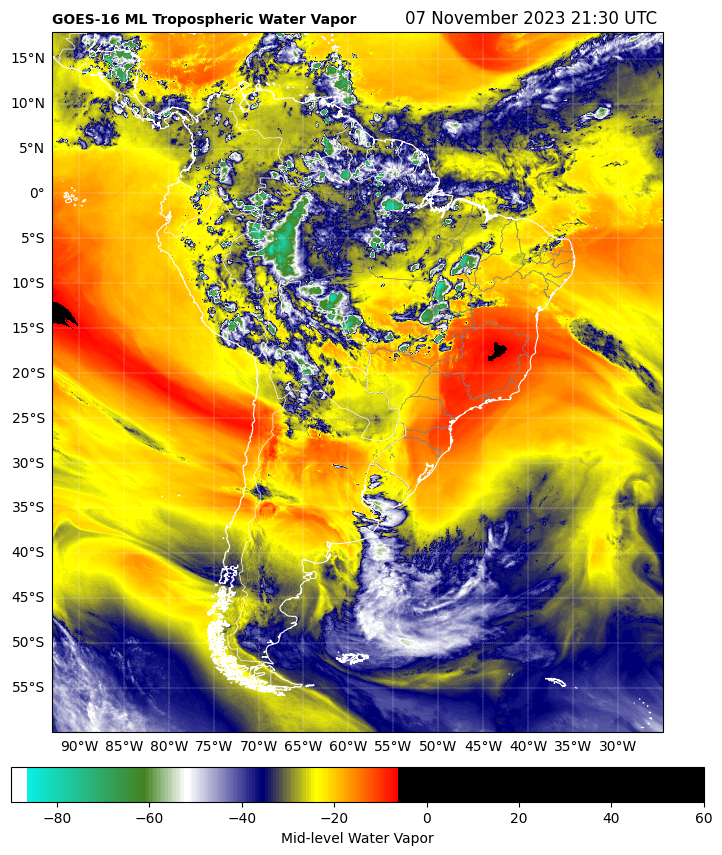

In [ ]:
# Load the the thermal infrared arrays
ML = ds['CMI_C09'][:,:].data - 273.15

# Choose the plot size (width x height, in inches)
plt.figure(figsize=(12,10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-103.3))
extent=ax.set_extent([-93.0, -25.0, -60.0, 18.0], crs=ccrs.PlateCarree())

# Converts the CPT file to be used in Python
cpt = loadCPT('WVCOLOR35.cpt')

# Makes a linear interpolation with the CPT file
cpt_convert = LinearSegmentedColormap('cpt', cpt)

# Plot the image
img = plt.imshow(ML, vmin=-90, vmax=60.00,cmap=cpt_convert, origin='upper', extent=extent, transform=ccrs.Geostationary(central_longitude=-75.0, satellite_height=35786023.0))

# Add a shapefile
# https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2019/Brasil/BR/br_unidades_da_federacao.zip
shapefile = list(shpreader.Reader('BR_UF_2019.shp').geometries())
ax.add_geometries(shapefile, ccrs.PlateCarree(), edgecolor='gray',facecolor='none', linewidth=0.3)

# Add coastlines, borders and gridlines
ax.coastlines(resolution='10m', color='white', linewidth=0.8)
ax.add_feature(cartopy.feature.BORDERS, edgecolor='white', linewidth=0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), color='white', alpha=1.0, linestyle='--', linewidth=0.25, xlocs=np.arange(-180, 180, 5), ylocs=np.arange(-90, 90, 5), draw_labels=True)
gl.top_labels = False
gl.right_labels = False

plt.colorbar(img, label='Mid-level Water Vapor', orientation='horizontal', pad=0.045, fraction=0.045)

plt.title('GOES-16 ML Tropospheric Water Vapor', loc='left', fontweight='bold', fontsize=10)
plt.title('{}'.format(scan_start.strftime('%d %B %Y %H:%M UTC ')), loc='right')
#plt.savefig('infrared_'+scan_start.strftime('%Y-%m-%d %H:%M')+'.png', bbox_inches='tight', pad_inches=0, dpi=100)


plt.show()

# Flash Ocurrence

The Geostationary Lightning Mapper is a single-channel, near-infrared optical transient detector that can detect the momentary changes in an optical scene, indicating the presence of lightning. GLM measures total lightning (in-cloud, cloud-to-cloud and cloud-to-ground) activity continuously over the Americas and adjacent ocean regions with near-uniform spatial resolution of approximately 10 km. GLM collects information such as the frequency, location and extent of lightning discharges to identify intensifying thunderstorms and tropical cyclones. Trends in total lightning available from the GLM. In this case, we will add a known library for producing a color palette, known as custom_color_palette

In [ ]:
!pip install custom_color_palette

We will analyze the data from the dx dataset.

In [ ]:
dx

<xarray.Dataset>
Dimensions:                                 (number_of_events: 14166,
                                             number_of_groups: 5624,
                                             number_of_flashes: 450,
                                             number_of_time_bounds: 2,
                                             number_of_wavelength_bounds: 2,
                                             number_of_field_of_view_bounds: 2)
Coordinates: (12/25)
    event_id                                (number_of_events) uint32 3807799...
    event_time_offset                       (number_of_events) datetime64[ns] ...
    event_lat                               (number_of_events) float64 2.731 ...
    event_lon                               (number_of_events) float64 -74.32...
    event_parent_group_id                   (number_of_events) uint32 1520004...
    group_id                                (number_of_groups) uint32 1520004...
    ...                                      ...
    lat_field_of_view                       float32 0.0
    lon_field_of_view                       float32 -75.0
    dataset_name                            <U69 'OR_GLM-L2-LCFA_G16_s2023311...
    date_created                            <U22 '2023-11-07T21:42:01.7Z'
    time_coverage_start                     <U22 '2023-11-07T21:41:40.0Z'
    time_coverage_end                       <U22 '2023-11-07T21:42:00.0Z'
Dimensions without coordinates: number_of_events, number_of_groups,
                                number_of_flashes, number_of_time_bounds,
                                number_of_wavelength_bounds,
                                number_of_field_of_view_bounds
Data variables: (12/28)
    event_energy                            (number_of_events) float32 2.625e...
    group_frame_time_offset                 (number_of_groups) datetime64[ns] ...
    group_area                              (number_of_groups) float32 6.425e...
    group_energy                            (number_of_groups) float32 2.585e...
    group_quality_flag                      (number_of_groups) float32 0.0 .....
    flash_frame_time_offset_of_first_event  (number_of_flashes) datetime64[ns] ...
    ...                                      ...
    lon_field_of_view_bounds                (number_of_field_of_view_bounds) float32 ...
    percent_uncorrectable_L0_errors         float32 0.0
    algorithm_dynamic_input_data_container  int32 -2147483647
    processing_parm_version_container       int32 -2147483647
    algorithm_product_version_container     int32 -2147483647
    filename                                <U105 'noaa-goes16/GLM-L2-LCFA/20...
Attributes: (12/26)
    production_site:           RBU
    featureType:               point
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    institution:               DOC/NOAA/NESDIS> U.S. Department of Commerce, ...
    project:                   GOES
    ...                        ...
    spatial_resolution:        8km at nadir
    production_data_source:    Realtime
    production_environment:    OE
    LUT_Filenames:             GLM_CALINR_AllFilters(FM1E_CDRL79RevK_DO_09_00...
    id:                        891ebcea-232d-47b6-9103-c3d0823df9eb
    path:                      ['noaa-goes16/GLM-L2-LCFA/2023/311/21/OR_GLM-L...

And now we will extract the latitudes and longitudes from this dataset so that we can analyze the points which showed lightning during the analyzed period.Along with this, we will use the temporal data of the rays in order to be able to represent during the scan period the region of occurrence and the period during the scan that that ray occurred.

In [ ]:
flash_lon = dx['flash_lon']
flash_lat = dx['flash_lat']

time_bounds = dx['product_time_bounds']
time_start = time_bounds.data[0]
time_end = time_bounds.data[-1]

ti = dx['flash_time_offset_of_first_event']
tf = dx['flash_time_offset_of_last_event']
flash_time = ti.data+(tf.data-ti.data)/2.0

from matplotlib.dates import date2num
flash_time_num = date2num(flash_time)

Below, we will create the color palette, using the new installed library and thus normalizing the values.

In [ ]:
# import packages
import custom_color_palette as ccp
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.dates import DateFormatter
ncols = 6

# set the colors of the custom palette
palette = [['gold','orange','red','darkviolet','violet'], ccp.range(1,ncols,1)]

# pass parameters to the creates_palette module
cmap, cmticks, norm, bounds = ccp.creates_palette([palette], extend='both')

# creates ticks for colorbar
ticks = np.linspace(date2num(time_start),date2num(time_end),ncols)

# calculates norm
norm = Normalize(vmin=ticks[0], vmax=ticks[-1])

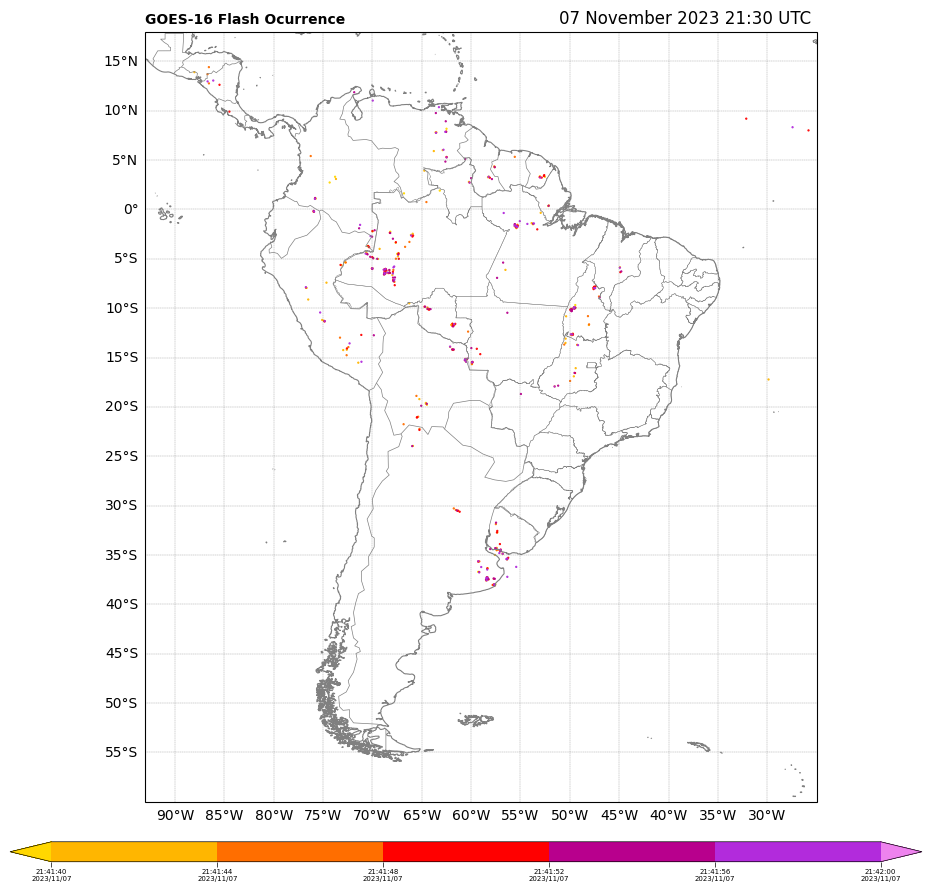

In [ ]:
# Choose the plot size (width x height, in inches)
fig = plt.figure(figsize=(12,10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-103.3))
extent=ax.set_extent([-93.0, -25.0, -60.0, 18.0], crs=ccrs.PlateCarree())

# plot the data
img = ax.scatter(flash_lon.data, flash_lat.data, s=0.40, c=flash_time_num, cmap=cmap, norm=norm,
                 marker='o', transform=ccrs.PlateCarree())

# Add a shapefile
# https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2019/Brasil/BR/br_unidades_da_federacao.zip
shapefile = list(shpreader.Reader('BR_UF_2019.shp').geometries())
ax.add_geometries(shapefile, ccrs.PlateCarree(), edgecolor='gray',facecolor='none', linewidth=0.3)

# Add coastlines, borders and gridlines
ax.coastlines(resolution='10m', color='gray', linewidth=0.8)
ax.add_feature(cartopy.feature.BORDERS, edgecolor='gray', linewidth=0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), color='gray', alpha=1.0, linestyle='--', linewidth=0.25, xlocs=np.arange(-180, 180, 5), ylocs=np.arange(-90, 90, 5), draw_labels=True)
gl.top_labels = False
gl.right_labels = False

plt.title('GOES-16 Flash Ocurrence', loc='left', fontweight='bold', fontsize=10)
plt.title('{}'.format(scan_start.strftime('%d %B %Y %H:%M UTC ')), loc='right')

# add the colorbar
cb = plt.colorbar(img, ticks=ticks, format=DateFormatter('%H:%M:%S\n%Y/%m/%d'), extend='both',
                    spacing='proportional', orientation='horizontal',
                    cax=fig.add_axes([0.12, 0.05, 0.76, 0.02]))
cb.ax.tick_params(labelsize=5, labelcolor='black', width=0.5, direction='out', pad=1.0)
cb.outline.set_linewidth(0.5)

plt.show()

# Top Cloud Temperature + Flash Ocurrence


In construction...

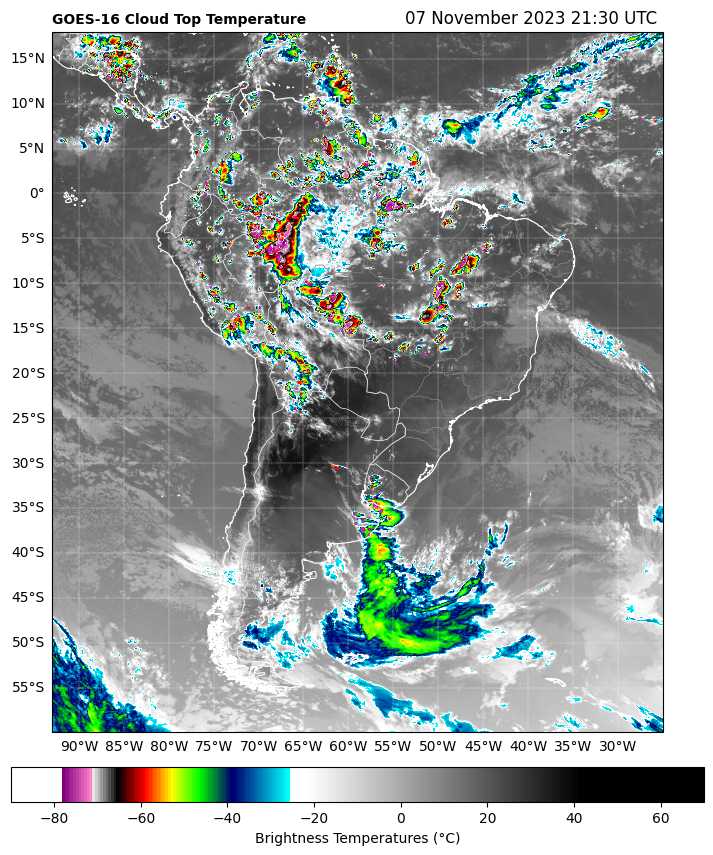

In [ ]:
# Choose the plot size (width x height, in inches)
fig = plt.figure(figsize=(12,10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-103.3))
extent=ax.set_extent([-93.0, -25.0, -60.0, 18.0], crs=ccrs.PlateCarree())

# Converts the CPT file to be used in Python
cpt = loadCPT('IR4AVHRR6.cpt')

# Makes a linear interpolation with the CPT file
cpt_convert = LinearSegmentedColormap('cpt', cpt)

# Plot the image
img = plt.imshow(IR, vmin=-90, vmax=70,cmap=cpt_convert, origin='upper', extent=extent, transform=ccrs.Geostationary(central_longitude=-75.0, satellite_height=35786023.0))


# plot the data
img1 = ax.scatter(flash_lon.data, flash_lat.data, s=1.0, c=flash_time_num, cmap=cmap, norm=norm,
                 marker='h', transform=ccrs.PlateCarree())

# Add a shapefile
# https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2019/Brasil/BR/br_unidades_da_federacao.zip
shapefile = list(shpreader.Reader('BR_UF_2019.shp').geometries())
ax.add_geometries(shapefile, ccrs.PlateCarree(), edgecolor='gray',facecolor='none', linewidth=0.3)

# Add coastlines, borders and gridlines
ax.coastlines(resolution='10m', color='white', linewidth=0.8)
ax.add_feature(cartopy.feature.BORDERS, edgecolor='white', linewidth=0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), color='white', alpha=1.0, linestyle='--', linewidth=0.25, xlocs=np.arange(-180, 180, 5), ylocs=np.arange(-90, 90, 5), draw_labels=True)
gl.top_labels = False
gl.right_labels = False

plt.colorbar(img, label='Brightness Temperatures (°C)', orientation='horizontal', pad=0.045, fraction=0.045)

plt.title('GOES-16 Cloud Top Temperature', loc='left', fontweight='bold', fontsize=10)
plt.title('{}'.format(scan_start.strftime('%d %B %Y %H:%M UTC ')), loc='right')
#plt.savefig('infrared_'+scan_start.strftime('%Y-%m-%d %H:%M')+'.png', bbox_inches='tight', pad_inches=0, dpi=100)

plt.show()

